# Network Analysis

In [ ]:
# https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools

import networkx as nx
#import nxviz
#from nxviz.plots import MatrixPlot, ArcPlot, CircosPlot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
seaborn.set()


from community import community_louvain

from prettytable import PrettyTable

from pyvis.network import Network
#import plotly.offline as py
#import plotly.graph_objects as go

In [2]:
def create_edgelist(entity_list, retweets):
    """
    Creates a weighted edgelist based on entity co-occurence.
    
        Parameters:
            entity_list (list): List of lists of entities occuring together.
        
        Returns:
            df_edgelist (dataframe): Pandas dataframe that shows number of co-occurances of different entities. 
    """
    
    print("\nCreating Edgelist...\n\n")
    
    cooccurence_dict = defaultdict(lambda: defaultdict(int))
    
    # Iterate over all entity co-occurences
    for cooccurence, retweet in zip(entity_list,retweets):
    
    # Check whether more than one entity is available
        if len(cooccurence) > 1:
    
        # Get all possible combinations of entities
            combinations = list(itertools.combinations(sorted(cooccurence), 2))
            
    
            # Increment count of entity co-occurences by retweet count + 1
            for combination in combinations:
                cooccurence_dict[combination]["Co_Occurence"] += 1
                cooccurence_dict[combination]["Retweet"] += (retweet+1)             
        
    # Convert dict to dataframe
    #df_edgelist = pd.Series(cooccurance_dict).reset_index()
    #df_edgelist.columns = ['Entity_1', 'Entity_2', 'Weight']
    
    df_edgelist = pd.DataFrame.from_dict(cooccurence_dict, orient="index")
    df_edgelist.reset_index(inplace=True)
    df_edgelist.rename({"level_0":"Entity_1","level_1":"Entity_2"},axis=1, inplace=True)
    df_edgelist = df_edgelist[df_edgelist["Entity_1"] != df_edgelist["Entity_2"]]
    
    # Return edgelist dataframe
    return df_edgelist

In [3]:
def get_entity_count(series):
    dict_count = defaultdict(int)
    
    for entities in series:
        for entity in entities:
            if len(entity) > 0:
                dict_count[entity] += 1
            
    return dict_count

In [4]:
def create_overall_graph(df,df_edgelist,entity = "hashtags"):
    print("\nCreating the Overall Graph...\n\n")

    G = nx.Graph()
    
    for entity_1,entity_2,weight in zip(df_edgelist["Entity_1"],
                                        df_edgelist["Entity_2"],
                                        df_edgelist["Weight"]):
        G.add_edge(entity_1,entity_2, weight = weight, width=weight)
    
    
    print(nx.info(G))
    print("\n----------------------------------------------\n\n")

    entity_count = get_entity_count(df[entity])
    degree_centrality = nx.degree_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, weight = "weight")
    size = {k:v/max(degree_centrality.values())*30 for (k,v) in degree_centrality.items()}

    nx.set_node_attributes(G, entity_count, "entity_count" )
    nx.set_node_attributes(G, degree_centrality, "Degree Centrality")
    nx.set_node_attributes(G, eigenvector_centrality, "Eigenvector Centrality")
    nx.set_node_attributes(G, size, "size")
    
    df_node_attributes = pd.DataFrame.from_dict(dict(G.nodes(data=True)),
                                            orient="index").reset_index().rename({"index":"entity"}, axis = 1)
    df_node_attributes = df_node_attributes.sort_values(by="Degree Centrality", ascending=False).reset_index(drop=True)
    
    print(f"Most important {entity} in the network:")
    print(df_node_attributes[["entity","entity_count","Degree Centrality"]].head(15))
    print("\n----------------------------------------------\n\n")
    
    return G, df_node_attributes

In [5]:
def create_subgraph(df_node_attributes, G, node_count = 50, filename = "abc.html"):
    print("\nCreating Subgraph...\n\n")
    
    cut_off = df_node_attributes.loc[node_count,"Degree Centrality"]
    selected_nodes = [n for n,v in G.nodes(data=True) if v["Degree Centrality"]>cut_off]
    
    G_sub = G.subgraph(selected_nodes)
    
    partition = community_louvain.best_partition(G_sub, random_state=42)
    print(f"Identified {len(set(partition.values()))} clusters.")
    
    colors_partition = {k:v for (k,v) in colors.items() if k < len(set(partition.values()))}
    
    node_colors = {k:colors_partition[v] for (k,v) in partition.items()}
    
    nx.set_node_attributes(G_sub, partition, "Partiton")
    nx.set_node_attributes(G_sub, node_colors, "color")
    
    print("\nPlotting Graph...\n\n")
    n = Network(height = "1500px", width ="100%", font_color ="#616a6b ")
    #n.show_buttons()
    n.from_nx(G_sub)
    n.barnes_hut()
    n.show_buttons(filter_=["nodes","edges","physics"])
    n.show(filename)
    print("\nGraph succesfully plotted\n\n")

In [6]:
def all_in_one(df, entity, filename,node_count=50, weighting = "Retweet"):
    
    df_edgelist = create_edgelist(list(df[entity]), list(df["retweet_count_sum"]))
    df_edgelist["Weight"] = df_edgelist[weighting]/(max(df_edgelist[weighting])/25)
    df_edgelist = df_edgelist.sort_values(by="Weight", ascending=False)
    
    print(f"Most frequently co-occuring hashtags sorted by {weighting}:")
    print(df_edgelist[["Entity_1","Entity_2","Co_Occurence","Retweet"]].head(15))
    print("\n----------------------------------------------\n\n")
    
    G, df_node_attributes = create_overall_graph(df,
                                                 df_edgelist,
                                                 entity = entity)
    
    create_subgraph(df_node_attributes, G, node_count = node_count, filename = filename)

In [7]:
def element_in_list(entities,qualifiers):

    return not(bool(set(entities).isdisjoint(set(qualifiers))))

In [8]:
def group_df(df,interval):
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
    elif interval == "day":
        col_name = "date"
    
    
    df_grouped = df.groupby([col_name])[['refugee', 'migrant', 'immigrant', 'asylum_seeker', 'other']].sum()
    df_grouped["total"] = df_grouped.sum(axis=1)
    
    return df_grouped

In [18]:
def plot_event_timeline(df, interval):
    
    df_grouped = group_df(df,interval)
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["total"], color=colors[0])
    #plt.title(f"Number of tweets about refugees and related groups by {interval}")
    plt.xticks(np.arange(0, len(df_grouped)+1,3),rotation=90)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["refugee"], label ="refugee",color=colors[0])
    plt.plot(df_grouped["migrant"], label ="migrant",color=colors[1])
    plt.plot(df_grouped["immigrant"], label ="immigrant",color=colors[2])
    plt.plot(df_grouped["asylum_seeker"], label ="asylum seeker",color=colors[3])
    plt.plot(df_grouped["other"], label ="other",color=colors[4])
    #plt.title(f"Grouped number of tweets about refugees and related groups by {interval}")
    plt.xticks(np.arange(0, len(df_grouped)+1,3),rotation=90)
    plt.legend(prop={'size': 15})
    plt.show()

In [29]:
def plot_hashtags(df):

    d = defaultdict(lambda: defaultdict(int))
    
    # Count occurences and retweets per hashtags
    for i,(hashtags,retweets) in df[["hashtags","retweet_count"]].iterrows():

        for hashtag in set(hashtags):
            if len(hashtag) > 0:
                d[hashtag]["count"] += 1
                d[hashtag]["retweets"] += retweets
                
    d_top_10 = dict(sorted(d.items(), key=lambda x: x[1]['count'], reverse=True)[:15])
    df_top_10 = pd.DataFrame(d_top_10).transpose()
    
    # Visualise hashtags in bar plot
    df_top_10.plot.barh(width=0.8,figsize=(25,15),color=[colors[2],colors[0]])
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(prop={'size': 25})
    plt.show()
    
    # Print most frequent hashtags
    print(df_top_10)

In [10]:
def hashtag_analysis(df,hashtags):
    df = df[df["hashtags"].apply(lambda x: element_in_list(x,hashtags))].sort_values("retweet_count", ascending=False).head(10)
    df = df[["id","text","retweet_count"]]
    
    for i,(ID,tweet, retweets) in df.iterrows():
        print(tweet)
        print(f"Retweets: {retweets}")
        print(f"ID: {ID}")
        print("---------------------------------")
        print

In [51]:
def plot_entity_timeline(df, interval, entity_list, entity_type):
    
    plt.figure(figsize=(16, 8))
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
    elif interval == "day":
        col_name = "date"
    
    #df_to_plot = pd.DataFrame()
    df_to_plot = pd.DataFrame(index=df[col_name].drop_duplicates().values)
    
    for entity in entity_list:
        df_entity = df[df[entity_type].apply(lambda x: element_in_list(x,[entity]))]
        df_grouped = group_df(df_entity,interval)["total"]
        df_to_plot[entity] = df_grouped
    
    plt.plot(df_to_plot)
    
    plt.xticks(rotation=90)
    plt.legend(df_to_plot.columns)
    plt.show()

In [11]:
colors = {0:"#6495ED",
          1:"#9FE2BF",
          2:"#FFBF00",
          3:"#717d7e",
          4:"#cb4335",
          5:"#7d3c98",
          6:"#273746",
          7:"#196f3d "}

## Import the data

In [12]:
df_greece = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\Event Dataframes\Clean\df_greece_clean.csv",
                        converters = {"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})
# Drop unnecessary index column
df_greece.drop("Unnamed: 0", axis=1, inplace=True)
df_greece.head()

,source,text,lang,id,created_at,author_id,retweet_count,reply_count,like_count,quote_count,...,migrant,immigrant,asylum_seeker,other,date,text_coherent,retweet_count_sum,count,text_alphanum,text_stm
0,Hootsuite Inc.,PA Ambassador in Bosnia &amp; Herzegovina says...,en,1227019550912372737,2020-02-11 00:00:32+00:00,81136269,1,0,1,0,...,False,False,False,False,2020-02-11,PA Ambassador in Bosnia & Herzegovina says lif...,1,1,pa ambassador in bosnia herzegovina says life ...,ambassador bosnia herzegovina say life europe ...
1,u.fooo.ooo,[🔴 NEWS] Greece plans floating sea border wall...,en,1227019556167864321,2020-02-11 00:00:33+00:00,1052191553802854407,0,0,0,0,...,False,False,False,False,2020-02-11,[ NEWS] Greece plans floating sea border wall ...,0,1,news greece plans floating sea border wall to...,news greece plan floating border wall keep
2,Twitter Web Client,Latest Battle for Idlib Could Send Another Wav...,en,1227021374780313601,2020-02-11 00:07:47+00:00,18570470,0,0,1,1,...,False,False,False,False,2020-02-11,Latest Battle for Idlib Could Send Another Wav...,8,5,latest battle for idlib could send another wav...,latest battle idlib send another wave europe w...
3,Tweepsmap,UNHCR calls for decisive action to end alarmin...,en,1227021789525614594,2020-02-11 00:09:26+00:00,62632306,0,0,0,0,...,False,False,False,False,2020-02-11,UNHCR calls for decisive action to end alarmin...,9,3,unhcr calls for decisive action to end alarmin...,unhcr call decisive action alarming condition ...
4,Twitter for iPhone,"It is not your own feet sinking in the mud, bo...",en,1227022233484308481,2020-02-11 00:11:12+00:00,2729959018,9,1,29,1,...,False,False,False,False,2020-02-11,"It is not your own feet sinking in the mud, boy.",9,1,it is not your own feet sinking in the mud boy.,foot sinking


In [13]:
df_channel = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\Event Dataframes\Clean\df_channel_clean.csv",
                         converters = {"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                       "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                       "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})
# Drop unnecessary index column
df_channel.drop("Unnamed: 0", axis=1, inplace=True)
#df_channel.head()

In [14]:
df_tigray = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\Event Dataframes\Clean\df_tigray_clean.csv",
                        converters = {"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})
# Drop unnecessary index column
df_tigray.drop("Unnamed: 0", axis=1, inplace=True)
#df_tigray.head()

In [15]:
df_rohingya = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\Event Dataframes\Clean\df_rohingya_clean.csv",
                        converters = {"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                      "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})
# Drop unnecessary index column
df_rohingya.drop("Unnamed: 0", axis=1, inplace=True)
#df_rohingya.head()

## Greece

### Timeline

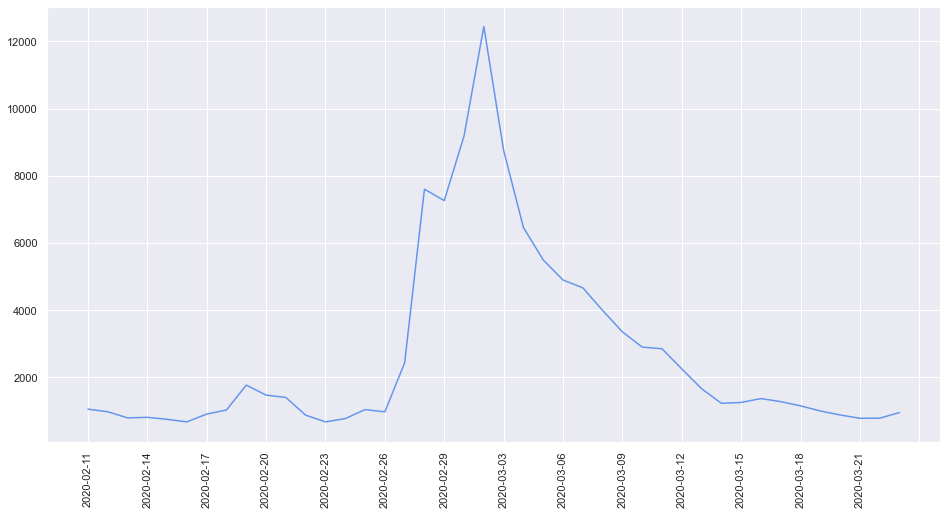

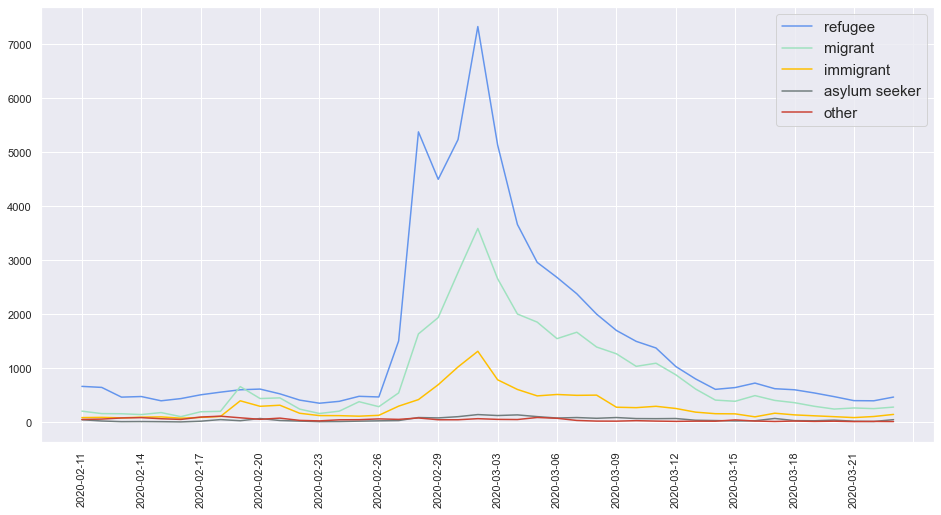

In [19]:
plot_event_timeline(df_greece,"day")

### Hashtags

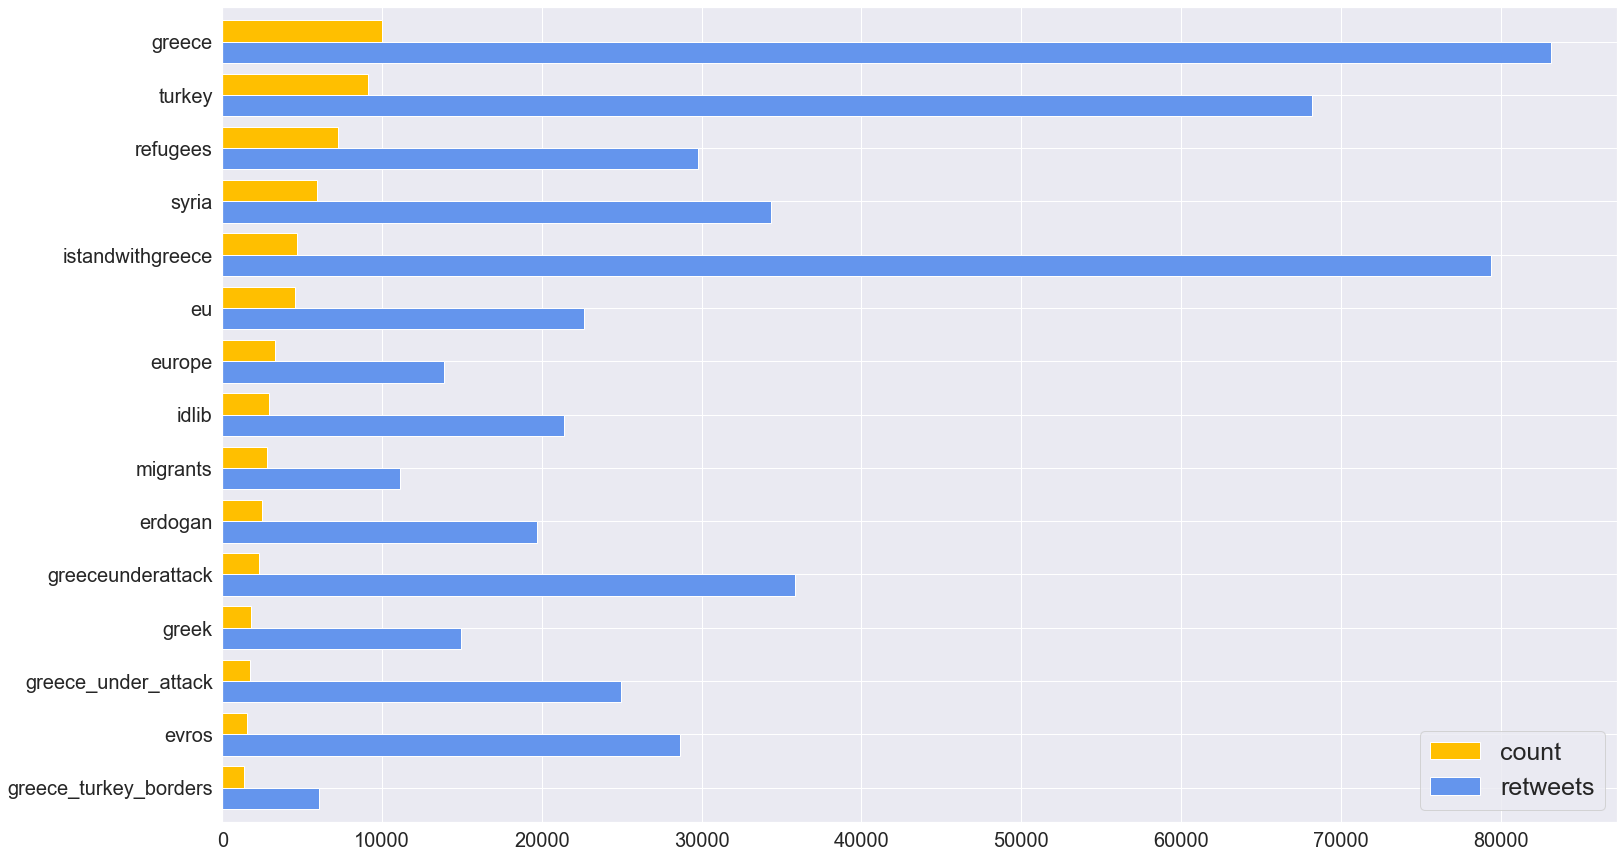

                       count  retweets
greece                 10021     83152
turkey                  9146     68205
refugees                7255     29789
syria                   5930     34335
istandwithgreece        4686     79412
eu                      4578     22629
europe                  3321     13847
idlib                   2897     21369
migrants                2776     11141
erdogan                 2510     19686
greeceunderattack       2303     35862
greek                   1785     14964
greece_under_attack     1733     24959
evros                   1548     28626
greece_turkey_borders   1358      6039


In [28]:
plot_hashtags(df_greece)

In [42]:
hashtag_analysis(df_greece,["istandwithgreece","greeceunderattack","greecedefendseurope","greece_turkey_borders"])

Fake immigrants standing  by the river, are taking  their clothes off  to get photographed. in order  to accuse Greece. That's how the Turkish propaganda works.  #IStandWithGreece #greece_under_attack #GreeceDefendsEurope https://t.co/8s8JgT2WkC
Retweets: 2417
ID: 1235945899513262080
---------------------------------
Bulgarian authorities, after Greek request, opened the Ivaylovgrad dam, so that river Evros at the Greek-Turkish border, floods.
This way it will be harder for migrants to cross.

#IStandWithGreece
#GreeceUnderAttack 
#Greece_under_attack https://t.co/1yLGbShg8O
Retweets: 1640
ID: 1237365651737583616
---------------------------------
#Breaking #Greek farmers ready to block immigrants in #Evros    
 
#GreeceUnderAttack #IStandWithGreece https://t.co/6vbU2cfPZv
Retweets: 1633
ID: 1234154143599808516
---------------------------------
Notice how all the “refugees” trying to invade Greece are fighting-age-men.

What could go wrong? #IStandWithGreece https://t.co/SfJy8uBsdM
Retw

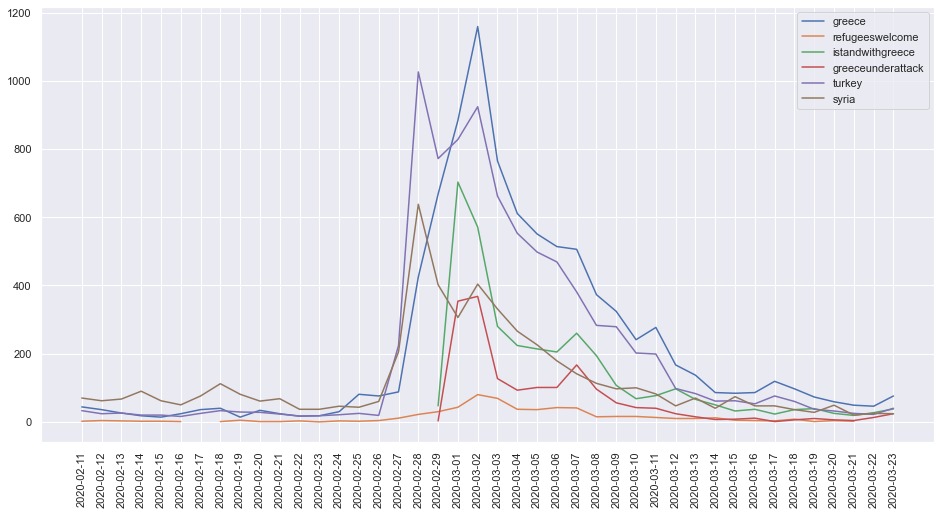

In [59]:
plot_entity_timeline(df_greece, "day", ["greece","refugeeswelcome","istandwithgreece","greeceunderattack","turkey","syria"], "hashtags")

### Networks

In [41]:
all_in_one(df_greece,"hashtags","nw_greece_hashtags.html", weighting="Co_Occurence")


Creating Edgelist...


Most frequently co-occuring hashtags sorted by Co_Occurence:
                Entity_1          Entity_2  Co_Occurence  Retweet
48                greece            turkey          3955    44678
575               greece          refugees          2645    19062
1373            refugees            turkey          2586    15474
102                syria            turkey          2345    16120
291                   eu            turkey          1820     9683
107             refugees             syria          1686     8280
218                   eu            greece          1543    12143
226                idlib             syria          1468    12428
37                europe            turkey          1401     9012
1496             erdogan            turkey          1312    15234
170               greece          migrants          1288     6837
155                   eu          refugees          1232     5203
202             migrants            turkey          1141 

In [ ]:
all_in_one(df_greece,"mentions","nw_greece_mentions_retweet.html",weighting="Co_Occurence")

## Channel

### Timeline

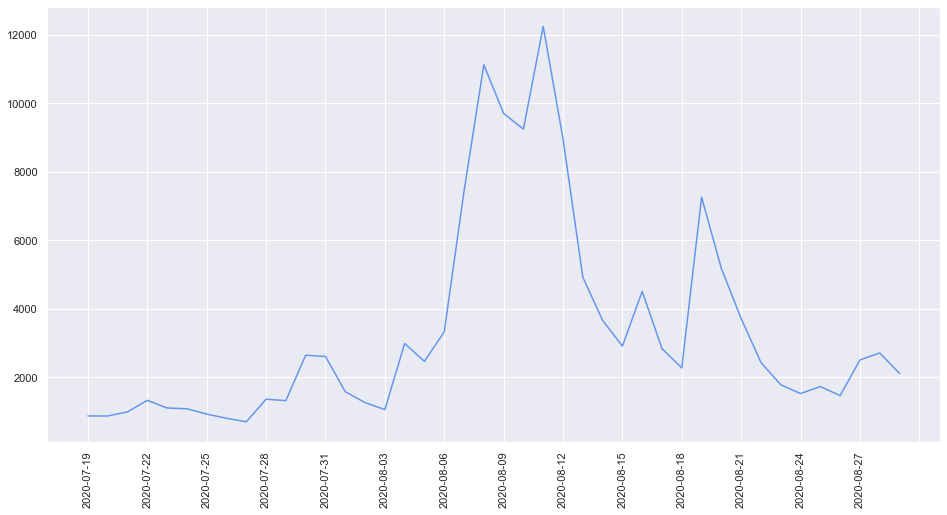

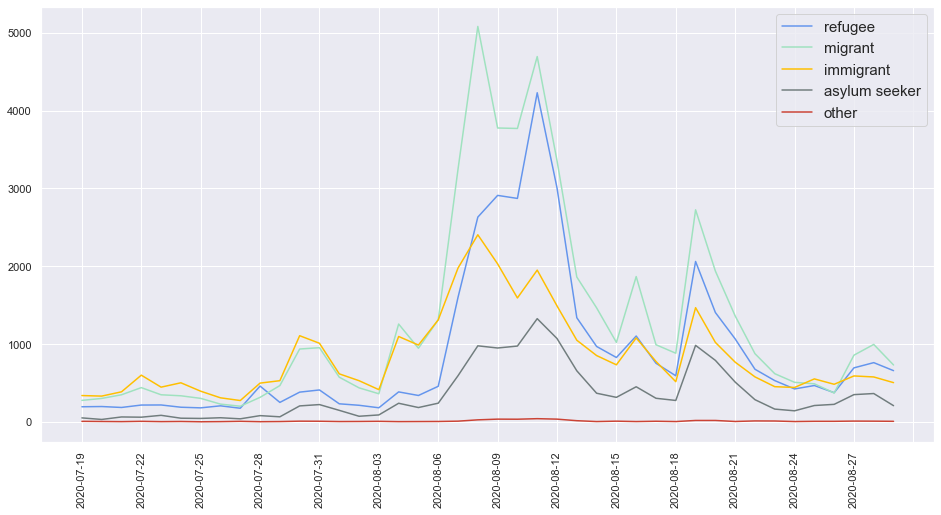

In [31]:
plot_event_timeline(df_channel,"day")

### Hashtags

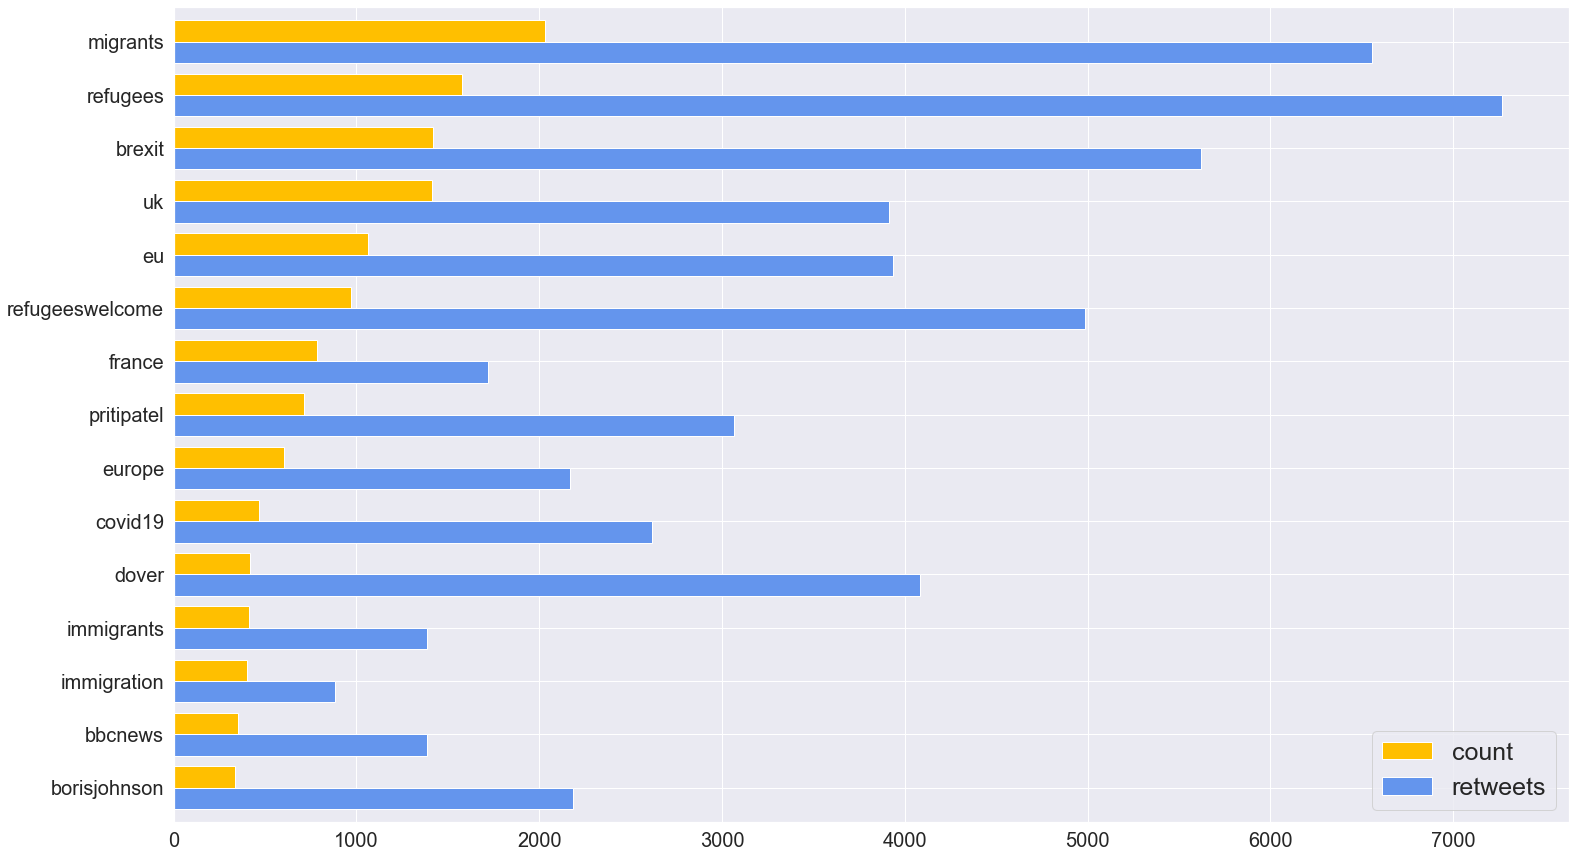

                 count  retweets
migrants          2032      6554
refugees          1576      7268
brexit            1417      5621
uk                1411      3912
eu                1065      3935
refugeeswelcome    970      4984
france             786      1722
pritipatel         711      3067
europe             603      2166
covid19            464      2614
dover              417      4083
immigrants         413      1387
immigration        401       885
bbcnews            354      1383
borisjohnson       334      2185


In [32]:
plot_hashtags(df_channel)

In [30]:
#hashtag_analysis(df_channel,["istandwithgreece","greeceunderattack","greecedefendseurope","greece_turkey_borders"])

Fake immigrants standing  by the river, are taking  their clothes off  to get photographed. in order  to accuse Greece. That's how the Turkish propaganda works.  #IStandWithGreece #greece_under_attack #GreeceDefendsEurope https://t.co/8s8JgT2WkC
Retweets: 2417
ID: 1235945899513262080
---------------------------------
Bulgarian authorities, after Greek request, opened the Ivaylovgrad dam, so that river Evros at the Greek-Turkish border, floods.
This way it will be harder for migrants to cross.

#IStandWithGreece
#GreeceUnderAttack 
#Greece_under_attack https://t.co/1yLGbShg8O
Retweets: 1640
ID: 1237365651737583616
---------------------------------
#Breaking #Greek farmers ready to block immigrants in #Evros    
 
#GreeceUnderAttack #IStandWithGreece https://t.co/6vbU2cfPZv
Retweets: 1633
ID: 1234154143599808516
---------------------------------
Notice how all the “refugees” trying to invade Greece are fighting-age-men.

What could go wrong? #IStandWithGreece https://t.co/SfJy8uBsdM
Retw

### Networks

In [ ]:
all_in_one(df_channel,"hashtags","nw_channel_hashtags.html", weighting="Co_Occurence")

In [ ]:
all_in_one(df_channel,"mentions","nw_channel_mentions_retweet.html",weighting="Co_Occurence")

## Tigray

### Timeline

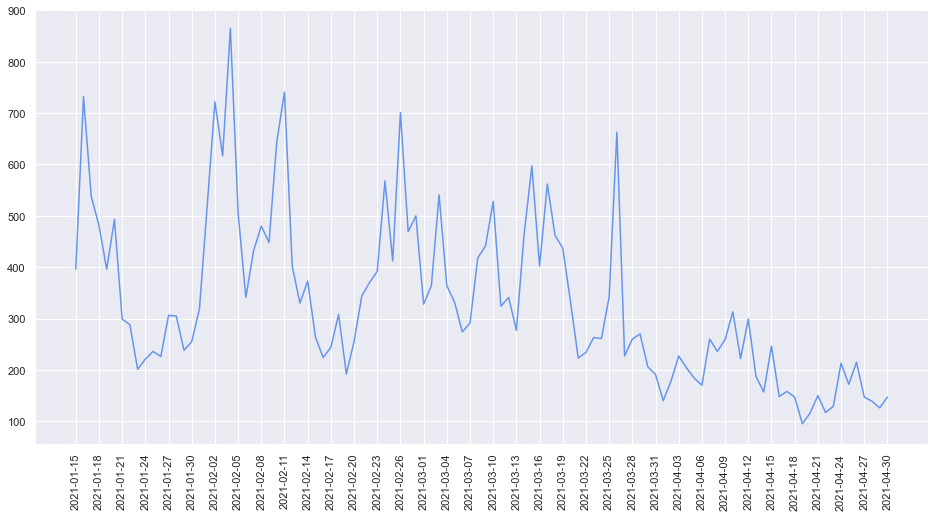

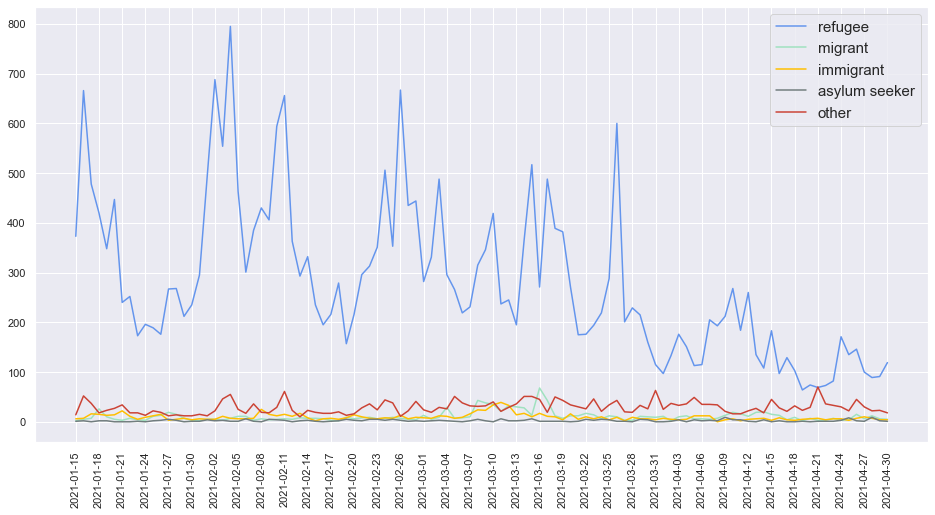

In [33]:
plot_event_timeline(df_tigray,"day")

### Hashtags

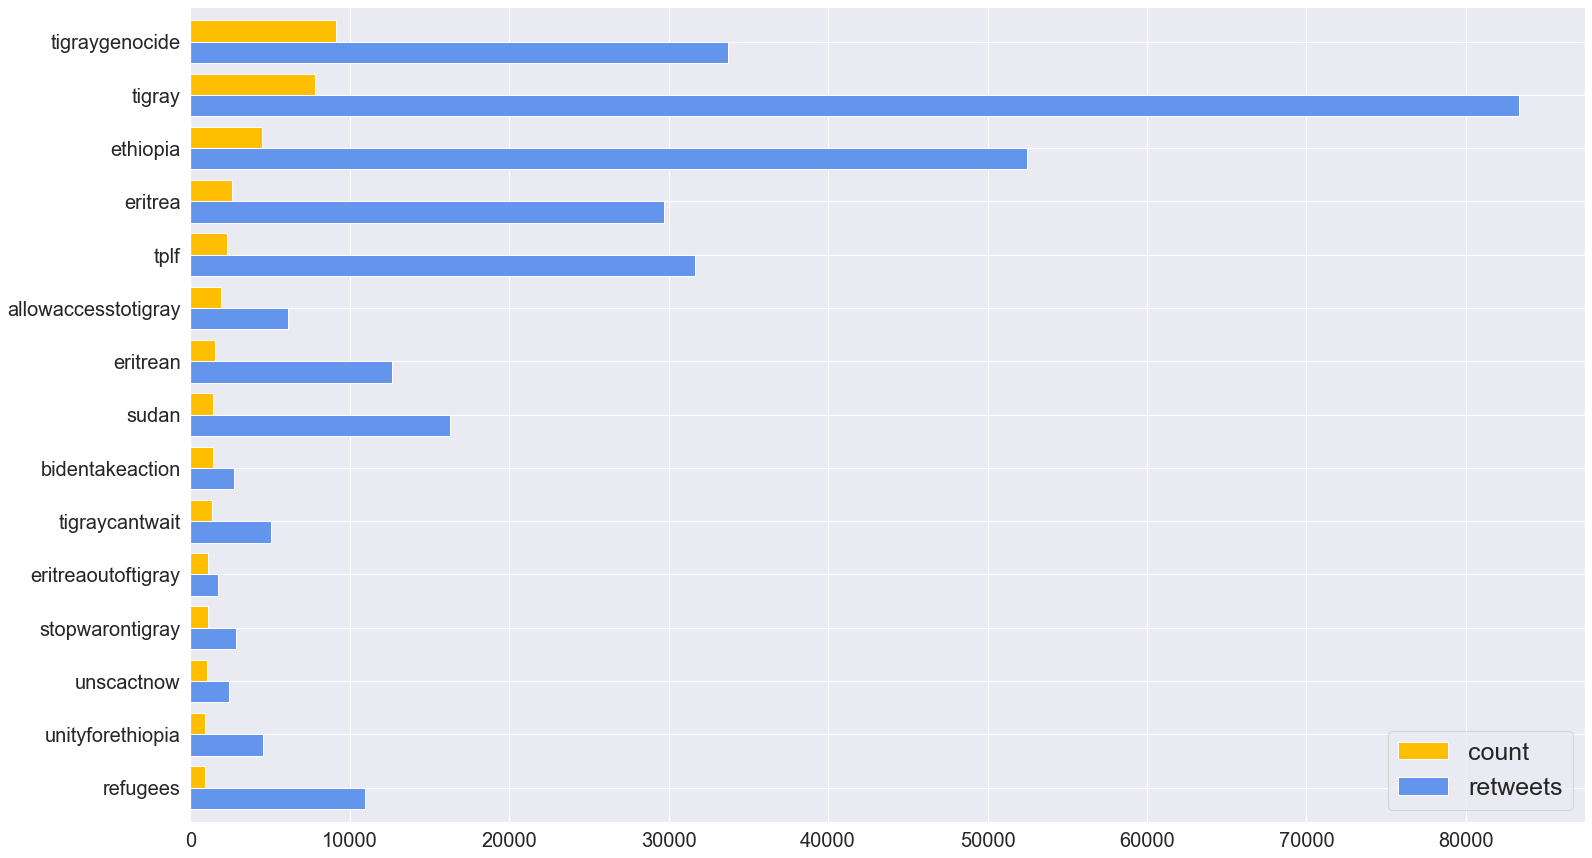

                     count  retweets
tigraygenocide        9156     33745
tigray                7838     83316
ethiopia              4516     52451
eritrea               2592     29735
tplf                  2308     31686
allowaccesstotigray   1905      6104
eritrean              1552     12627
sudan                 1457     16264
bidentakeaction       1410      2777
tigraycantwait        1351      5098
eritreaoutoftigray    1134      1733
stopwarontigray       1120      2883
unscactnow            1056      2456
unityforethiopia       954      4553
refugees               935     10978


In [34]:
plot_hashtags(df_tigray)

In [30]:
#hashtag_analysis(df_greece,["istandwithgreece","greeceunderattack","greecedefendseurope","greece_turkey_borders"])

Fake immigrants standing  by the river, are taking  their clothes off  to get photographed. in order  to accuse Greece. That's how the Turkish propaganda works.  #IStandWithGreece #greece_under_attack #GreeceDefendsEurope https://t.co/8s8JgT2WkC
Retweets: 2417
ID: 1235945899513262080
---------------------------------
Bulgarian authorities, after Greek request, opened the Ivaylovgrad dam, so that river Evros at the Greek-Turkish border, floods.
This way it will be harder for migrants to cross.

#IStandWithGreece
#GreeceUnderAttack 
#Greece_under_attack https://t.co/1yLGbShg8O
Retweets: 1640
ID: 1237365651737583616
---------------------------------
#Breaking #Greek farmers ready to block immigrants in #Evros    
 
#GreeceUnderAttack #IStandWithGreece https://t.co/6vbU2cfPZv
Retweets: 1633
ID: 1234154143599808516
---------------------------------
Notice how all the “refugees” trying to invade Greece are fighting-age-men.

What could go wrong? #IStandWithGreece https://t.co/SfJy8uBsdM
Retw

### Networks

In [ ]:
all_in_one(df_tigray,"hashtags","nw_tigray_hashtags.html", weighting="Co_Occurence")

In [ ]:
all_in_one(df_tigray,"mentions","nw_tigray_mentions.html", weighting="Co_Occurence")

## Myanmar

### Timeline

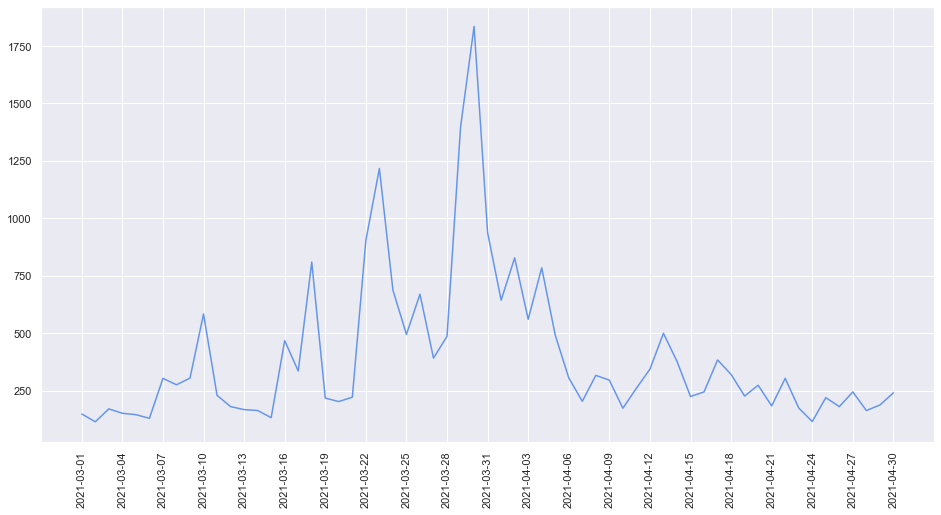

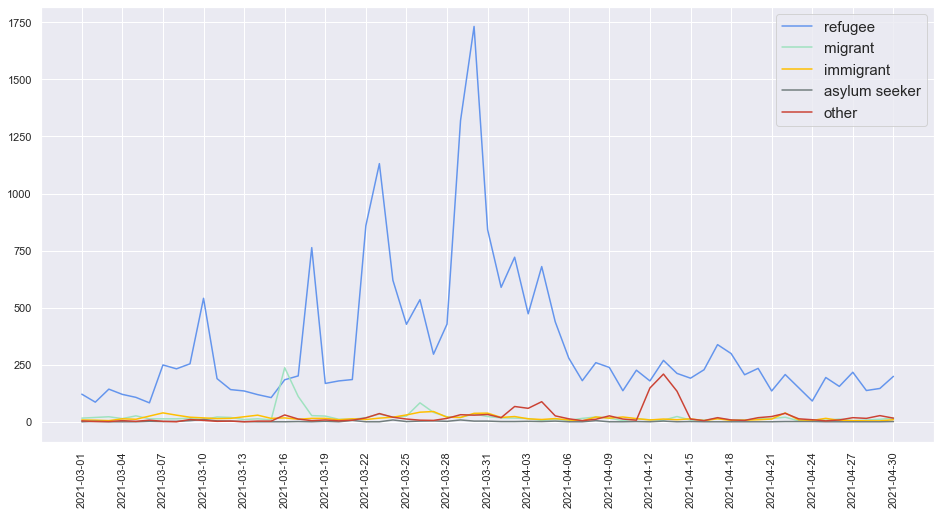

In [35]:
plot_event_timeline(df_rohingya,"day")

### Hashtags

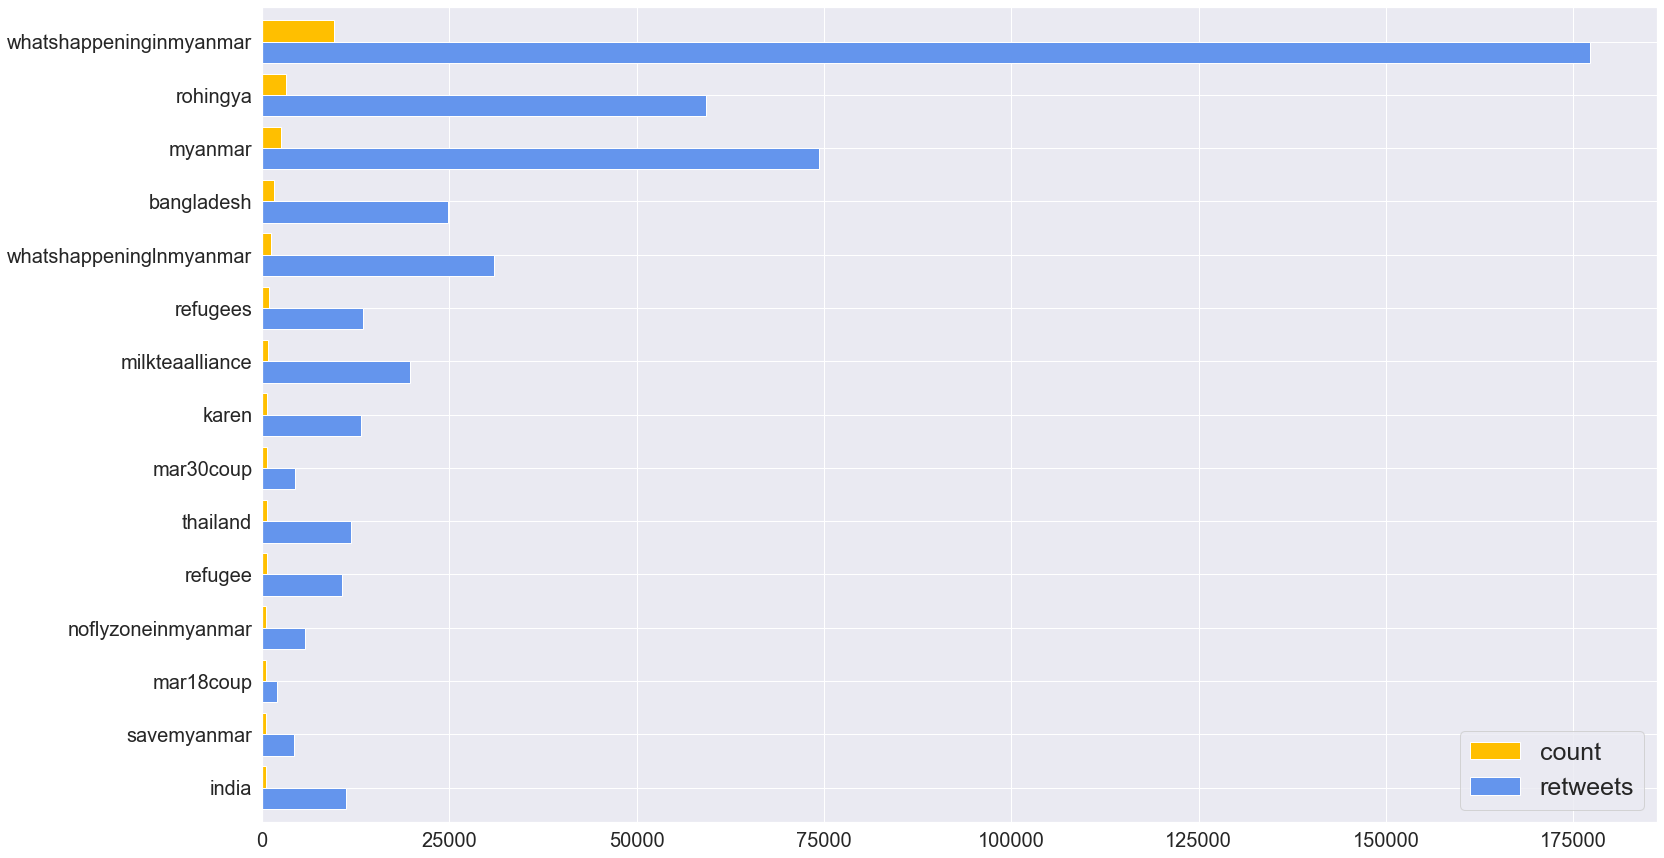

                         count  retweets
whatshappeninginmyanmar   9632    177282
rohingya                  3245     59244
myanmar                   2502     74293
bangladesh                1607     24832
whatshappeninglnmyanmar   1186     30987
refugees                   994     13466
milkteaalliance            765     19810
karen                      701     13263
mar30coup                  681      4438
thailand                   646     11902
refugee                    633     10732
noflyzoneinmyanmar         586      5808
mar18coup                  559      1989
savemyanmar                541      4357
india                      501     11214


In [36]:
plot_hashtags(df_rohingya)

In [30]:
# hashtag_analysis(df_greece,["istandwithgreece","greeceunderattack","greecedefendseurope","greece_turkey_borders"])

Fake immigrants standing  by the river, are taking  their clothes off  to get photographed. in order  to accuse Greece. That's how the Turkish propaganda works.  #IStandWithGreece #greece_under_attack #GreeceDefendsEurope https://t.co/8s8JgT2WkC
Retweets: 2417
ID: 1235945899513262080
---------------------------------
Bulgarian authorities, after Greek request, opened the Ivaylovgrad dam, so that river Evros at the Greek-Turkish border, floods.
This way it will be harder for migrants to cross.

#IStandWithGreece
#GreeceUnderAttack 
#Greece_under_attack https://t.co/1yLGbShg8O
Retweets: 1640
ID: 1237365651737583616
---------------------------------
#Breaking #Greek farmers ready to block immigrants in #Evros    
 
#GreeceUnderAttack #IStandWithGreece https://t.co/6vbU2cfPZv
Retweets: 1633
ID: 1234154143599808516
---------------------------------
Notice how all the “refugees” trying to invade Greece are fighting-age-men.

What could go wrong? #IStandWithGreece https://t.co/SfJy8uBsdM
Retw

### Networks

In [ ]:
all_in_one(df_rohingya,"hashtags","nw_rohingya_hashtags.html", weighting="Co_Occurence")

In [ ]:
all_in_one(df_rohingya,"mentions","nw_rohingya_mentions.html", weighting="Co_Occurence")

## Create edgelist

In [ ]:
df_edgelist_hash = create_edgelist(list(df_tigray["hashtags"]), list(df_tigray["retweet_count_sum"]))
df_edgelist_hash["Co_Occurence_Norm"] = df_edgelist_hash["Co_Occurence"]/(max(df_edgelist_hash["Co_Occurence"])/10)
df_edgelist_hash["Retweet_Norm"] = df_edgelist_hash["Retweet"]/(max(df_edgelist_hash["Retweet"])/10)
df_edgelist_hash

In [ ]:
#df_edgelist_hash = create_edgelist(list(df_greece["hashtags"])).sort_values(by="Weight",ascending=False).reset_index()
#df_edgelist_hash = df_edgelist_hash[df_edgelist_hash["Entity_1"] != df_edgelist_hash["Entity_2"]]

## Create graph

In [ ]:
G_hashtag = nx.Graph()
for entity_1,entity_2,weight in zip(df_edgelist_hash["Entity_1"],
                                    df_edgelist_hash["Entity_2"],
                                    df_edgelist_hash["Co_Occurence_Norm"]):
    G_hashtag.add_edge(entity_1,entity_2, weight = weight, width=weight) #0.005

In [ ]:
print(nx.info(G_hashtag))

## Provide node metadata

In [ ]:
hashtag_count = get_entity_count(df_tigray["hashtags"])

# Degree Centrality: 
degree_centrality = nx.degree_centrality(G_hashtag)

eigenvector_centrality = nx.eigenvector_centrality(G_hashtag, weight = "weight")

#size = {k:v*100 for (k,v) in degree_centrality.items()}
size = {k:v/max(degree_centrality.values())*10 for (k,v) in degree_centrality.items()}

In [ ]:
max(degree_centrality.values())

In [ ]:
nx.set_node_attributes(G_hashtag, hashtag_count, "hashtag_count" )
nx.set_node_attributes(G_hashtag, degree_centrality, "Degree Centrality")
nx.set_node_attributes(G_hashtag, eigenvector_centrality, "Eigenvector Centrality")
nx.set_node_attributes(G_hashtag, size, "size")

## Calculate network measures

In [ ]:
# Density: Ratio of actual edges in the network to all possible edges
#density = nx.density(G_hashtag)
# Transitivity: Ration of all triangles over all possible triangles (triadic closure)
#trans = nx.transitivity(G_hashtag)
# Reciprocity:
#reci = nx.reciprocity(G_hashtag)

#print(f"Density: {density}\nTransitivity: {trans}\nReciprocity: {reci}")

In [ ]:
# Diameter: Longest of all shortest paths in network
#nx.is_connected(G_hashtag)
# nx.diameter(G_hashtag)
# nx.average_shortest_path_length(G)

#components = nx.connected_components(G_hashtag)
#largest_component = max(components, key=len)
#subgraph = G_hashtag.subgraph(largest_component)
#diameter = nx.diameter(subgraph)
#print("Network diameter of largest component:", diameter)

## Create df with node attributes

In [ ]:
df_node_attributes = pd.DataFrame.from_dict(dict(G_hashtag.nodes(data=True)),
                                            orient="index").reset_index().rename({"index":"hashtag"}, axis = 1)
df_node_attributes = df_node_attributes.sort_values(by="Degree Centrality", ascending=False).reset_index(drop=True)
df_node_attributes.head(15)

## Create subgraph that only consists of top 50 nodes with highest degree centrality

In [ ]:
cut_off = df_node_attributes.loc[50,"Degree Centrality"]
selected_nodes = [n for n,v in G_hashtag.nodes(data=True) if v["Degree Centrality"]>cut_off]

In [ ]:
G_hashtag_sub = G_hashtag.subgraph(selected_nodes)

## Identify clusters

In [ ]:
partition = community_louvain.best_partition(G_hashtag_sub, random_state=42)
print(f"Identified {len(set(partition.values()))} clusters.")

In [ ]:
for i in range (len(set(partition.values()))):
    print([k for k,v in partition.items() if v == i])
    print("------")

In [ ]:
partition

In [ ]:
colors_partition = {k:v for (k,v) in colors.items() if k < len(set(partition.values()))}

In [ ]:
node_colors = {k:colors_partition[v] for (k,v) in partition.items()}

In [ ]:
nx.set_node_attributes(G_hashtag_sub, partition, "Partition")
nx.set_node_attributes(G_hashtag_sub, node_colors, "color")

In [ ]:
df_node_attributes1 = pd.DataFrame.from_dict(dict(G_hashtag_sub.nodes(data=True)),
                                            orient="index").reset_index().rename({"index":"hashtag"}, axis = 1)
df_node_attributes1 = df_node_attributes1.sort_values(by=["Partition","Degree Centrality"], ascending=[True,False]).reset_index(drop=True)
df_node_attributes1

## Draw network graph

In [ ]:
G_hashtag_sub.nodes(data=True)

In [ ]:
n = Network(height = "1500px", width ="100%", font_color ="#616a6b ")
#n.show_buttons()
n.from_nx(G_hashtag_sub)
n.barnes_hut()
n.show_buttons(filter_=["nodes","edges","physics"])
n.show("network_test.html")